In [2]:

import pandas as pd
import seaborn as sns

In [3]:
ls

results_eval.ipynb
Untitled.ipynb
wandb_export_2022-08-26T10_40_14.642-04_00.csv
wandb_export_2022-08-29T09_52_50.373-04_00.csv
wandb_export_2022-08-31T16_24_21.563-04_00.csv
wandb_export_2022-09-12T11_49_31.689-04_00.csv
wandb_export_2022-09-13T14_36_54.025-04_00.csv


In [4]:
df = pd.read_csv("wandb_export_2022-08-31T16_24_21.563-04_00.csv")

In [5]:
df2 = pd.read_csv("wandb_export_2022-09-13T14_36_54.025-04_00.csv")

In [6]:
df = pd.concat([df, df2]).reset_index(drop=True)
# -1 implies no chebyshev
df["datamodule/transform_args/cheb_order"] = df["datamodule/transform_args/cheb_order"].fillna("exact")

In [7]:
df["datamodule/transform_args/power"] = df["datamodule/transform_args/power"].fillna(2)

In [8]:
df["datamodule/transform_args/power"].value_counts()

1.0    1750
2.0     600
Name: datamodule/transform_args/power, dtype: int64

In [44]:
def get_model(x):
    power, tau = x
    if power == 2:
        return r"$\wtwo$"
    if tau == "exact":
        return r"$\wone$ (exact)"
    else:
        return r"$\wone$ ($\tau=%d$)" % (int(tau))
clean_df = df.rename(columns={"datamodule/transform_args/alpha": r"$\alpha$", 
                              "datamodule/transform_args/power": "power", 
                              "datamodule/dataset": "dataset","test/acc": "acc",
                              "datamodule/transform_args/cheb_order": r"$\tau$",
                             })
clean_df["power"] = clean_df["power"].astype(int)
clean_df[r"$\alpha$"] = clean_df[r"$\alpha$"].round(2) #apply(lambda x: f"{x:0.2}")
clean_df = clean_df.replace("PTC_MR", "PTC MR")
clean_df["model"] = clean_df[["power", r"$\tau$"]].apply(get_model, axis=1)
clean_df

,Name,State,Notes,Tags,acc,$\alpha$,dataset,ckpt_path,model/net/hidden_dims,seed,power,$\tau$,model
0,cool-feather-1662,finished,-,"lr, power1, v6",0.367045,0.5,IMDB-MULTI,None,NaN,9,1,exact,$\wone$ (exact)
1,eager-voice-1661,finished,-,"lr, power1, v6",0.366477,0.5,IMDB-MULTI,None,NaN,8,1,exact,$\wone$ (exact)
2,proud-silence-1660,finished,-,"lr, power1, v6",0.409659,0.5,IMDB-MULTI,None,NaN,7,1,exact,$\wone$ (exact)
3,spring-firefly-1659,finished,-,"lr, power1, v6",0.397159,0.5,IMDB-MULTI,None,NaN,6,1,exact,$\wone$ (exact)
4,comic-paper-1658,finished,-,"lr, power1, v6",0.376136,0.5,IMDB-MULTI,None,NaN,5,1,exact,$\wone$ (exact)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,driven-salad-1668,finished,-,"cheb, lr, power1, v7",0.683048,0.0,NCI1,None,NaN,4,1,10.0,$\wone$ ($\tau=10$)
2346,elated-oath-1667,finished,-,"cheb, lr, power1, v7",0.680199,0.0,NCI1,None,NaN,3,1,10.0,$\wone$ ($\tau=10$)
2347,radiant-pyramid-1666,finished,-,"cheb, lr, power1, v7",0.627315,0.0,NCI1,None,NaN,2,1,10.0,$\wone$ ($\tau=10$)
2348,cerulean-eon-1665,finished,-,"cheb, lr, power1, v7",0.675392,0.0,NCI1,None,NaN,1,1,10.0,$\wone$ ($\tau=10$)


In [17]:
def process_line(means, highlight, highlight_index, highlight_max):
    if highlight:
        if highlight_max:
            tops = set(means.groupby(highlight_index).idxmax())
        else:
            tops = set(means.groupby(highlight_index).idxmin())
    else:
        tops = set()
    def process_line(x):
        if x.name in tops:
            return rf"\textbf{{{x['mean']:0.3f} $\pm$ {x['std']:0.3f}}}"
        return rf"{x['mean']:0.3f} $\pm$ {x['std']:0.3f}"
    return process_line
def mean_pm_std(data, index, columns, value, highlight=True, highlight_cols=True, highlight_max=True):
    assert len(data) > 0
    groupby = data.groupby([*index, *columns])
    means = groupby.mean()[value].rename("mean")
    stds = groupby.std()[value].rename("std")
    ddf = pd.concat([means, stds], axis=1).T
    highlight_index = columns if highlight_cols else index
    ddf = ddf.apply(process_line(means, highlight, highlight_index, highlight_max))
    ddf = ddf.reset_index().pivot(index=index, columns=columns)
    ddf.columns = ddf.columns.droplevel(level=0)
    return ddf
    #for i in range(len(means)):
        #means.iloc[i,:]
#mean_pm_std(df[df["datamodule/transform_args/power"] == 1].groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]))


In [18]:
def rename(x):
    # print(x)
    return pd.Series(
        (x["acc"][0], x["acc"][1], int(x[0])), index=["power", r"$\alpha$", "count"]
    )


index = ["dataset", "seed"]
columns = ["power", r"$\alpha$"]
value = "acc"
res = (
    clean_df[
        ((clean_df[r"$\tau$"] == "exact") | (clean_df["power"] == 2))
        & (clean_df["dataset"] != "ENZYMES")
    ]
    .groupby([*index, *columns])
    .mean()[value]
    .reset_index()
    .set_index(columns)
    .groupby(index)
    .idxmax()
    .value_counts()
    .reset_index()
    .apply(rename, axis=1)
    .pivot(index=["power"], columns=[r"$\alpha$"])
    .T
)  # #.pivot(index=index, columns=columns)
res.index = res.index.droplevel(level=0)

In [19]:
res

power,1.0,2.0
$\alpha$,,
-0.50,12.0,2.0
-0.25,12.0,16.0
0.00,8.0,5.0
0.25,13.0,14.0
0.50,19.0,9.0


In [20]:
res_with_sum = pd.concat([res, pd.DataFrame(res.sum(axis=0).rename("sum")).T])
res_with_sum = pd.concat(
    [res_with_sum, pd.DataFrame(res_with_sum.sum(axis=1).rename("sum"))], axis=1
).astype(int)

print(
    res_with_sum.style.to_latex(
        hrules=True,
    )
)
res_with_sum

\begin{tabular}{lrrr}
\toprule
{} & {1.0} & {2.0} & {sum} \\
\midrule
-0.5 & 12 & 2 & 14 \\
-0.25 & 12 & 16 & 28 \\
0.0 & 8 & 5 & 13 \\
0.25 & 13 & 14 & 27 \\
0.5 & 19 & 9 & 28 \\
sum & 64 & 46 & 110 \\
\bottomrule
\end{tabular}



,1.0,2.0,sum
-0.5,12,2,14
-0.25,12,16,28
0.0,8,5,13
0.25,13,14,27
0.5,19,9,28
sum,64,46,110


In [21]:
df["datamodule/transform_args/cheb_order"].value_counts()

exact    1150
100.0     600
10.0      600
Name: datamodule/transform_args/cheb_order, dtype: int64

In [105]:
results = mean_pm_std(clean_df[((clean_df[r"$\tau$"] == "exact" ) | (clean_df["power"] == 2)) & (clean_df["dataset"] != "ENZYMES")], 
                      index=["power", r"$\alpha$"],
                      columns=["dataset"], value="acc").T
print(results.style.to_latex(hrules=True, ))
results

\begin{tabular}{lllllllllll}
\toprule
power & \multicolumn{5}{r}{1} & \multicolumn{5}{r}{2} \\
$\alpha$ & -0.500000 & -0.250000 & 0.000000 & 0.250000 & 0.500000 & -0.500000 & -0.250000 & 0.000000 & 0.250000 & 0.500000 \\
dataset &  &  &  &  &  &  &  &  &  &  \\
\midrule
COLLAB & 0.706 $\pm$ 0.006 & 0.701 $\pm$ 0.010 & 0.690 $\pm$ 0.007 & 0.705 $\pm$ 0.005 & \textbf{0.708 $\pm$ 0.006} & 0.699 $\pm$ 0.009 & 0.693 $\pm$ 0.007 & 0.694 $\pm$ 0.007 & 0.700 $\pm$ 0.007 & 0.705 $\pm$ 0.010 \\
DD & 0.727 $\pm$ 0.013 & 0.711 $\pm$ 0.026 & 0.714 $\pm$ 0.015 & 0.675 $\pm$ 0.041 & 0.651 $\pm$ 0.031 & 0.660 $\pm$ 0.014 & 0.674 $\pm$ 0.011 & 0.720 $\pm$ 0.017 & \textbf{0.732 $\pm$ 0.011} & 0.724 $\pm$ 0.021 \\
IMDB-BINARY & 0.698 $\pm$ 0.026 & 0.692 $\pm$ 0.038 & \textbf{0.713 $\pm$ 0.021} & 0.684 $\pm$ 0.015 & 0.666 $\pm$ 0.034 & 0.588 $\pm$ 0.012 & 0.579 $\pm$ 0.017 & 0.584 $\pm$ 0.019 & 0.609 $\pm$ 0.032 & 0.608 $\pm$ 0.031 \\
IMDB-MULTI & 0.397 $\pm$ 0.023 & 0.373 $\pm$ 0.014 & 0.421 $\pm$ 0.027 

power                            1                              \
$\alpha$                     -0.50                       -0.25   
dataset                                                          
COLLAB           0.706 $\pm$ 0.006           0.701 $\pm$ 0.010   
DD               0.727 $\pm$ 0.013           0.711 $\pm$ 0.026   
IMDB-BINARY      0.698 $\pm$ 0.026           0.692 $\pm$ 0.038   
IMDB-MULTI       0.397 $\pm$ 0.023           0.373 $\pm$ 0.014   
MUTAG            0.600 $\pm$ 0.000           0.770 $\pm$ 0.026   
NCI1             0.622 $\pm$ 0.006           0.650 $\pm$ 0.004   
NCI109           0.624 $\pm$ 0.010           0.676 $\pm$ 0.004   
PROTEINS         0.798 $\pm$ 0.013           0.791 $\pm$ 0.009   
PTC MR           0.423 $\pm$ 0.056  \textbf{0.456 $\pm$ 0.020}   
REDDIT-BINARY    0.789 $\pm$ 0.014           0.808 $\pm$ 0.017   
REDDIT-MULTI-5K  0.403 $\pm$ 0.007           0.410 $\pm$ 0.016   

power                                                                    \
$\alpha$                               0.00                        0.25   
dataset                                                                   
COLLAB                    0.690 $\pm$ 0.007           0.705 $\pm$ 0.005   
DD                        0.714 $\pm$ 0.015           0.675 $\pm$ 0.041   
IMDB-BINARY      \textbf{0.713 $\pm$ 0.021}           0.684 $\pm$ 0.015   
IMDB-MULTI                0.421 $\pm$ 0.027           0.406 $\pm$ 0.016   
MUTAG                     0.675 $\pm$ 0.063           0.690 $\pm$ 0.052   
NCI1                      0.638 $\pm$ 0.006           0.617 $\pm$ 0.011   
NCI109                    0.641 $\pm$ 0.004           0.673 $\pm$ 0.004   
PROTEINS                  0.778 $\pm$ 0.024           0.787 $\pm$ 0.012   
PTC MR                    0.384 $\pm$ 0.097           0.298 $\pm$ 0.102   
REDDIT-BINARY             0.820 $\pm$ 0.009  \textbf{0.842 $\pm$ 0.014}   
REDDIT-MULTI-5K           0.419 $\pm$ 0.011           0.433 $\pm$ 0.018   

power                                                                 2  \
$\alpha$                               0.50                       -0.50   
dataset                                                                   
COLLAB           \textbf{0.708 $\pm$ 0.006}           0.699 $\pm$ 0.009   
DD                        0.651 $\pm$ 0.031           0.660 $\pm$ 0.014   
IMDB-BINARY               0.666 $\pm$ 0.034           0.588 $\pm$ 0.012   
IMDB-MULTI                0.395 $\pm$ 0.031           0.335 $\pm$ 0.043   
MUTAG                     0.705 $\pm$ 0.055           0.775 $\pm$ 0.049   
NCI1             \textbf{0.696 $\pm$ 0.010}           0.651 $\pm$ 0.006   
NCI109                    0.679 $\pm$ 0.006           0.663 $\pm$ 0.010   
PROTEINS                  0.756 $\pm$ 0.020  \textbf{0.802 $\pm$ 0.016}   
PTC MR                    0.370 $\pm$ 0.063           0.366 $\pm$ 0.072   
REDDIT-BINARY             0.813 $\pm$ 0.010           0.814 $\pm$ 0.011   
REDDIT-MULTI-5K           0.420 $\pm$ 0.008           0.416 $\pm$ 0.007   

power                                                                    \
$\alpha$                              -0.25                        0.00   
dataset                                                                   
COLLAB                    0.693 $\pm$ 0.007           0.694 $\pm$ 0.007   
DD                        0.674 $\pm$ 0.011           0.720 $\pm$ 0.017   
IMDB-BINARY               0.579 $\pm$ 0.017           0.584 $\pm$ 0.019   
IMDB-MULTI                0.401 $\pm$ 0.045  \textbf{0.428 $\pm$ 0.016}   
MUTAG                     0.740 $\pm$ 0.039           0.640 $\pm$ 0.021   
NCI1                      0.649 $\pm$ 0.009           0.667 $\pm$ 0.004   
NCI109           \textbf{0.680 $\pm$ 0.008}           0.647 $\pm$ 0.008   
PROTEINS                  0.791 $\pm$ 0.038           0.783 $\pm$ 0.017   
PTC MR                    0.402 $\pm$ 0.051           0.443 $\pm$ 0.054   
REDDIT-BINARY             0.841 $\pm$ 0.007           0.825 $\pm$ 0.009  

In [102]:
results = mean_pm_std(clean_df[((clean_df[r"$\tau$"] == "exact" ) | (clean_df["power"] == 2)) & (clean_df[r"$\alpha$"] == 0.5) & (clean_df["dataset"] != "ENZYMES")], 
                      index=["power"],
                      columns=["dataset"], value="acc").T
print(results.style.to_latex(hrules=True, ))
results

\begin{tabular}{lll}
\toprule
power & 1 & 2 \\
dataset &  &  \\
\midrule
COLLAB & \textbf{0.708 $\pm$ 0.006} & 0.705 $\pm$ 0.010 \\
DD & 0.651 $\pm$ 0.031 & \textbf{0.724 $\pm$ 0.021} \\
IMDB-BINARY & \textbf{0.666 $\pm$ 0.034} & 0.608 $\pm$ 0.031 \\
IMDB-MULTI & 0.395 $\pm$ 0.031 & \textbf{0.419 $\pm$ 0.045} \\
MUTAG & \textbf{0.705 $\pm$ 0.055} & 0.590 $\pm$ 0.077 \\
NCI1 & \textbf{0.696 $\pm$ 0.010} & 0.659 $\pm$ 0.011 \\
NCI109 & \textbf{0.679 $\pm$ 0.006} & 0.642 $\pm$ 0.005 \\
PROTEINS & 0.756 $\pm$ 0.020 & \textbf{0.794 $\pm$ 0.016} \\
PTC MR & 0.370 $\pm$ 0.063 & \textbf{0.453 $\pm$ 0.017} \\
REDDIT-BINARY & \textbf{0.813 $\pm$ 0.010} & 0.795 $\pm$ 0.019 \\
REDDIT-MULTI-5K & \textbf{0.420 $\pm$ 0.008} & 0.391 $\pm$ 0.006 \\
\bottomrule
\end{tabular}



power,1,2
dataset,,
COLLAB,\textbf{0.708 $\pm$ 0.006},0.705 $\pm$ 0.010
DD,0.651 $\pm$ 0.031,\textbf{0.724 $\pm$ 0.021}
IMDB-BINARY,\textbf{0.666 $\pm$ 0.034},0.608 $\pm$ 0.031
IMDB-MULTI,0.395 $\pm$ 0.031,\textbf{0.419 $\pm$ 0.045}
MUTAG,\textbf{0.705 $\pm$ 0.055},0.590 $\pm$ 0.077
NCI1,\textbf{0.696 $\pm$ 0.010},0.659 $\pm$ 0.011
NCI109,\textbf{0.679 $\pm$ 0.006},0.642 $\pm$ 0.005
PROTEINS,0.756 $\pm$ 0.020,\textbf{0.794 $\pm$ 0.016}
PTC MR,0.370 $\pm$ 0.063,\textbf{0.453 $\pm$ 0.017}


In [54]:
results = mean_pm_std(clean_df[(clean_df[r"$\alpha$"] == 0)], 
                      index=["model"],
                      columns=["dataset"], value="acc").T
results

model,$W^1$ ($\tau=10$),$W^1$ ($\tau=100$),$W^1$ (exact),$W^2$
dataset,,,,
COLLAB,0.686 $\pm$ 0.010,\textbf{0.698 $\pm$ 0.005},0.690 $\pm$ 0.007,0.694 $\pm$ 0.007
DD,0.699 $\pm$ 0.017,0.696 $\pm$ 0.028,0.714 $\pm$ 0.015,\textbf{0.720 $\pm$ 0.017}
ENZYMES,0.221 $\pm$ 0.032,\textbf{0.242 $\pm$ 0.028},NaN,0.201 $\pm$ 0.023
IMDB-BINARY,0.683 $\pm$ 0.019,0.695 $\pm$ 0.012,\textbf{0.713 $\pm$ 0.021},0.584 $\pm$ 0.019
IMDB-MULTI,\textbf{0.444 $\pm$ 0.030},0.402 $\pm$ 0.014,0.421 $\pm$ 0.027,0.428 $\pm$ 0.016
MUTAG,\textbf{0.750 $\pm$ 0.035},0.735 $\pm$ 0.034,0.675 $\pm$ 0.063,0.640 $\pm$ 0.021
NCI1,0.663 $\pm$ 0.022,0.637 $\pm$ 0.017,0.638 $\pm$ 0.006,\textbf{0.667 $\pm$ 0.004}
NCI109,\textbf{0.675 $\pm$ 0.009},0.631 $\pm$ 0.013,0.641 $\pm$ 0.004,0.647 $\pm$ 0.008
PROTEINS,0.780 $\pm$ 0.024,\textbf{0.797 $\pm$ 0.013},0.778 $\pm$ 0.024,0.783 $\pm$ 0.017


In [18]:
results = mean_pm_std(clean_df[(clean_df[r"$\alpha$"] == 0) & (clean_df["power"] == 1)], index=[r"$\tau$"], columns=["dataset"], value="acc").T
results

$\tau$,10.0,100.0,exact
dataset,,,
COLLAB,0.686 $\pm$ 0.010,\textbf{0.698 $\pm$ 0.005},0.690 $\pm$ 0.007
DD,0.699 $\pm$ 0.017,0.696 $\pm$ 0.028,\textbf{0.714 $\pm$ 0.015}
ENZYMES,0.221 $\pm$ 0.032,\textbf{0.242 $\pm$ 0.028},NaN
IMDB-BINARY,0.683 $\pm$ 0.019,0.695 $\pm$ 0.012,\textbf{0.713 $\pm$ 0.021}
IMDB-MULTI,\textbf{0.444 $\pm$ 0.030},0.402 $\pm$ 0.014,0.421 $\pm$ 0.027
MUTAG,\textbf{0.750 $\pm$ 0.035},0.735 $\pm$ 0.034,0.675 $\pm$ 0.063
NCI1,\textbf{0.663 $\pm$ 0.022},0.637 $\pm$ 0.017,0.638 $\pm$ 0.006
NCI109,\textbf{0.675 $\pm$ 0.009},0.631 $\pm$ 0.013,0.641 $\pm$ 0.004
PROTEINS,0.780 $\pm$ 0.024,\textbf{0.797 $\pm$ 0.013},0.778 $\pm$ 0.024


In [45]:
cdf = clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df[r"$\tau$"] == "exact")].groupby(["seed", "model", r"$\alpha$"]).mean().reset_index()
cdf

# W1 vs W2 kernels across alpha
results = mean_pm_std(cdf, 
                      index=["model"], 
                      columns=[r"$\alpha$"], 
                      value="acc").T
print(results.style.to_latex(hrules=True, ))
results

\begin{tabular}{lll}
\toprule
{model} & {$\wone$ (exact)} & {$\wtwo$} \\
{$\alpha$} & {} & {} \\
\midrule
-0.5 & \textbf{0.617 $\pm$ 0.007} & 0.616 $\pm$ 0.012 \\
-0.25 & \textbf{0.640 $\pm$ 0.005} & 0.626 $\pm$ 0.009 \\
0.0 & \textbf{0.626 $\pm$ 0.012} & 0.623 $\pm$ 0.006 \\
0.25 & 0.619 $\pm$ 0.010 & \textbf{0.638 $\pm$ 0.008} \\
0.5 & \textbf{0.626 $\pm$ 0.009} & 0.616 $\pm$ 0.009 \\
\bottomrule
\end{tabular}



model,$\wone$ (exact),$\wtwo$
$\alpha$,,
-0.50,\textbf{0.617 $\pm$ 0.007},0.616 $\pm$ 0.012
-0.25,\textbf{0.640 $\pm$ 0.005},0.626 $\pm$ 0.009
0.00,\textbf{0.626 $\pm$ 0.012},0.623 $\pm$ 0.006
0.25,0.619 $\pm$ 0.010,\textbf{0.638 $\pm$ 0.008}
0.50,\textbf{0.626 $\pm$ 0.009},0.616 $\pm$ 0.009


In [20]:
clean_df

,Name,State,Notes,Tags,acc,$\alpha$,dataset,ckpt_path,model/net/hidden_dims,seed,power,$\tau$
0,cool-feather-1662,finished,-,"lr, power1, v6",0.367045,0.5,IMDB-MULTI,None,NaN,9,1,exact
1,eager-voice-1661,finished,-,"lr, power1, v6",0.366477,0.5,IMDB-MULTI,None,NaN,8,1,exact
2,proud-silence-1660,finished,-,"lr, power1, v6",0.409659,0.5,IMDB-MULTI,None,NaN,7,1,exact
3,spring-firefly-1659,finished,-,"lr, power1, v6",0.397159,0.5,IMDB-MULTI,None,NaN,6,1,exact
4,comic-paper-1658,finished,-,"lr, power1, v6",0.376136,0.5,IMDB-MULTI,None,NaN,5,1,exact
...,...,...,...,...,...,...,...,...,...,...,...,...
2345,driven-salad-1668,finished,-,"cheb, lr, power1, v7",0.683048,0.0,NCI1,None,NaN,4,1,10.0
2346,elated-oath-1667,finished,-,"cheb, lr, power1, v7",0.680199,0.0,NCI1,None,NaN,3,1,10.0
2347,radiant-pyramid-1666,finished,-,"cheb, lr, power1, v7",0.627315,0.0,NCI1,None,NaN,2,1,10.0
2348,cerulean-eon-1665,finished,-,"cheb, lr, power1, v7",0.675392,0.0,NCI1,None,NaN,1,1,10.0


In [47]:
cdf = clean_df[(clean_df["dataset"] != "ENZYMES")].groupby(["seed", "model", r"$\alpha$"]).mean().reset_index()
cdf["ckpt_path"] = "None"
cdf



# W1 vs W2 kernels across alpha
results1 = mean_pm_std(cdf, 
                      #index=[  r"$\alpha$",], 
                      index=["ckpt_path"], 
                      columns=[r"$\alpha$", "model"], 
                      highlight=True,
                      highlight_cols=False,
                      value="acc").T
results1.columns = ["Mean"]
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES")], 
                      #index=[  r"$\alpha$",], 
                      index=["dataset"], 
                      columns=[r"$\alpha$", "model"], 
                      highlight=True,
                      highlight_cols=False,
                      value="acc").T
results = pd.concat([results, results1], axis=1)

print(results.iloc[:, :6].style.to_latex(hrules=True))
print(results.iloc[:, 6:].style.to_latex(hrules=True))
results

\begin{tabular}{llllllll}
\toprule
{} & {} & {COLLAB} & {DD} & {IMDB-BINARY} & {IMDB-MULTI} & {MUTAG} & {NCI1} \\
{$\alpha$} & {model} & {} & {} & {} & {} & {} & {} \\
\midrule
\multirow[c]{4}{*}{-0.5} & $\wone$ ($\tau=10$) & 0.699 $\pm$ 0.005 & 0.654 $\pm$ 0.021 & \textbf{0.740 $\pm$ 0.022} & 0.384 $\pm$ 0.032 & 0.795 $\pm$ 0.064 & 0.657 $\pm$ 0.011 \\
 & $\wone$ ($\tau=100$) & 0.676 $\pm$ 0.008 & 0.721 $\pm$ 0.017 & 0.727 $\pm$ 0.021 & 0.438 $\pm$ 0.026 & 0.725 $\pm$ 0.035 & 0.681 $\pm$ 0.022 \\
 & $\wone$ (exact) & 0.706 $\pm$ 0.006 & 0.727 $\pm$ 0.013 & 0.698 $\pm$ 0.026 & 0.397 $\pm$ 0.023 & 0.600 $\pm$ 0.000 & 0.622 $\pm$ 0.006 \\
 & $\wtwo$ & 0.699 $\pm$ 0.009 & 0.660 $\pm$ 0.014 & 0.588 $\pm$ 0.012 & 0.335 $\pm$ 0.043 & 0.775 $\pm$ 0.049 & 0.651 $\pm$ 0.006 \\
\multirow[c]{4}{*}{-0.25} & $\wone$ ($\tau=10$) & 0.684 $\pm$ 0.008 & 0.683 $\pm$ 0.013 & 0.655 $\pm$ 0.036 & 0.438 $\pm$ 0.033 & 0.660 $\pm$ 0.070 & 0.642 $\pm$ 0.018 \\
 & $\wone$ ($\tau=100$) & 0.683 $\pm$ 0.007 & 0.69

COLLAB  \
$\alpha$ model                                              
-0.50    $\wone$ ($\tau=10$)            0.699 $\pm$ 0.005   
         $\wone$ ($\tau=100$)           0.676 $\pm$ 0.008   
         $\wone$ (exact)                0.706 $\pm$ 0.006   
         $\wtwo$                        0.699 $\pm$ 0.009   
-0.25    $\wone$ ($\tau=10$)            0.684 $\pm$ 0.008   
         $\wone$ ($\tau=100$)           0.683 $\pm$ 0.007   
         $\wone$ (exact)                0.701 $\pm$ 0.010   
         $\wtwo$                        0.693 $\pm$ 0.007   
 0.00    $\wone$ ($\tau=10$)            0.686 $\pm$ 0.010   
         $\wone$ ($\tau=100$)           0.698 $\pm$ 0.005   
         $\wone$ (exact)                0.690 $\pm$ 0.007   
         $\wtwo$                        0.694 $\pm$ 0.007   
 0.25    $\wone$ ($\tau=10$)            0.701 $\pm$ 0.010   
         $\wone$ ($\tau=100$)           0.690 $\pm$ 0.005   
         $\wone$ (exact)                0.705 $\pm$ 0.005   
         $\wtwo$                        0.700 $\pm$ 0.007   
 0.50    $\wone$ ($\tau=10$)            0.690 $\pm$ 0.007   
         $\wone$ ($\tau=100$)           0.670 $\pm$ 0.009   
         $\wone$ (exact)       \textbf{0.708 $\pm$ 0.006}   
         $\wtwo$                        0.705 $\pm$ 0.010   

                                                       DD  \
$\alpha$ model                                              
-0.50    $\wone$ ($\tau=10$)            0.654 $\pm$ 0.021   
         $\wone$ ($\tau=100$)           0.721 $\pm$ 0.017   
         $\wone$ (exact)                0.727 $\pm$ 0.013   
         $\wtwo$                        0.660 $\pm$ 0.014   
-0.25    $\wone$ ($\tau=10$)            0.683 $\pm$ 0.013   
         $\wone$ ($\tau=100$)           0.694 $\pm$ 0.026   
         $\wone$ (exact)                0.711 $\pm$ 0.026   
         $\wtwo$                        0.674 $\pm$ 0.011   
 0.00    $\wone$ ($\tau=10$)            0.699 $\pm$ 0.017   
         $\wone$ ($\tau=100$)           0.696 $\pm$ 0.028   
         $\wone$ (exact)                0.714 $\pm$ 0.015   
         $\wtwo$                        0.720 $\pm$ 0.017   
 0.25    $\wone$ ($\tau=10$)            0.697 $\pm$ 0.023   
         $\wone$ ($\tau=100$)           0.686 $\pm$ 0.021   
         $\wone$ (exact)                0.675 $\pm$ 0.041   
         $\wtwo$               \textbf{0.732 $\pm$ 0.011}   
 0.50    $\wone$ ($\tau=10$)            0.695 $\pm$ 0.021   
         $\wone$ ($\tau=100$)           0.695 $\pm$ 0.015   
         $\wone$ (exact)                0.651 $\pm$ 0.031   
         $\wtwo$                        0.724 $\pm$ 0.021   

                                              IMDB-BINARY  \
$\alpha$ model                                              
-0.50    $\wone$ ($\tau=10$)   \textbf{0.740 $\pm$ 0.022}   
         $\wone$ ($\tau=100$)           0.727 $\pm$ 0.021   
         $\wone$ (exact)                0.698 $\pm$ 0.026   
         $\wtwo$                        0.588 $\pm$ 0.012   
-0.25    $\wone$ ($\tau=10$)            0.655 $\pm$ 0.036   
         $\wone$ ($\tau=100$)           0.635 $\pm$ 0.051   
         $\wone$ (exact)                0.692 $\pm$ 0.038   
         $\wtwo$                        0.579 $\pm$ 0.017   
 0.00    $\wone$ ($\tau=10$)            0.683 $\pm$ 0.019   
         $\wone$ ($\tau=100$)           0.695 $\pm$ 0.012   
         $\wone$ (exact)                0.713 $\pm$ 0.021   
         $\wtwo$                        0.584 $\pm$ 0.019   
 0.25    $\wone$ ($\tau=10$)            0.688 $\pm$ 0.044   
         $\wone$ ($\tau=100$)           0.667 $\pm$ 0.012   
         $\wone$ (exact)                0.684 $\pm$ 0.015   
         $\wtwo$                        0.609 $\pm$ 0.032   
 0.50    $\wone$ ($\tau=10$)            0.680 $\pm$ 0.025   
         $\wone$ ($\tau=100$)           0.607 $\pm$ 0.008   
         $\wone$ (exact)                0.666 $\pm$ 0.034   
         $\wtwo$                        0.608 $\pm$ 0.031   

                      

In [22]:
# W1 vs W2 kernels across alpha
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES")], 
                      #index=[  r"$\alpha$",], 
                      index=[  "ckpt_path"], 
                      columns=["dataset", "power", r"$\tau$",], 
                      highlight=False,
                      value="acc").T
results.columns = ["Mean"]
#print(results.style.to_latex(hrules=True, ))

# W1 vs W2 kernels across alpha
results1 = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES")], 
                      index=[  r"$\alpha$",], 
                      #index=[  r"$\tau$",], 
                      columns=["dataset", "power",r"$\tau$",], 
                      value="acc").T

results = pd.concat([results1, results], axis=1)
print(results.style.to_latex(hrules=True, ))
results

\begin{tabular}{lllllllll}
\toprule
 &  &  & -0.500000 & -0.250000 & 0.000000 & 0.250000 & 0.500000 & Mean \\
dataset & power & $\tau$ &  &  &  &  &  &  \\
\midrule
\multirow[c]{4}{*}{COLLAB} & \multirow[c]{3}{*}{1} & 10.000000 & 0.699 $\pm$ 0.005 & 0.684 $\pm$ 0.008 & 0.686 $\pm$ 0.010 & \textbf{0.701 $\pm$ 0.010} & 0.690 $\pm$ 0.007 & 0.692 $\pm$ 0.010 \\
 &  & 100.000000 & 0.676 $\pm$ 0.008 & 0.683 $\pm$ 0.007 & \textbf{0.698 $\pm$ 0.005} & 0.690 $\pm$ 0.005 & 0.670 $\pm$ 0.009 & 0.683 $\pm$ 0.012 \\
 &  & exact & 0.706 $\pm$ 0.006 & 0.701 $\pm$ 0.010 & 0.690 $\pm$ 0.007 & 0.705 $\pm$ 0.005 & \textbf{0.708 $\pm$ 0.006} & 0.702 $\pm$ 0.009 \\
 & 2 & exact & 0.699 $\pm$ 0.009 & 0.693 $\pm$ 0.007 & 0.694 $\pm$ 0.007 & 0.700 $\pm$ 0.007 & \textbf{0.705 $\pm$ 0.010} & 0.698 $\pm$ 0.009 \\
\multirow[c]{4}{*}{DD} & \multirow[c]{3}{*}{1} & 10.000000 & 0.654 $\pm$ 0.021 & 0.683 $\pm$ 0.013 & \textbf{0.699 $\pm$ 0.017} & 0.697 $\pm$ 0.023 & 0.695 $\pm$ 0.021 & 0.685 $\pm$ 0.025 \\
 &  & 100.0

-0.5  \
dataset         power $\tau$                               
COLLAB          1     10.0             0.699 $\pm$ 0.005   
                      100.0            0.676 $\pm$ 0.008   
                      exact            0.706 $\pm$ 0.006   
                2     exact            0.699 $\pm$ 0.009   
DD              1     10.0             0.654 $\pm$ 0.021   
                      100.0   \textbf{0.721 $\pm$ 0.017}   
                      exact   \textbf{0.727 $\pm$ 0.013}   
                2     exact            0.660 $\pm$ 0.014   
IMDB-BINARY     1     10.0    \textbf{0.740 $\pm$ 0.022}   
                      100.0   \textbf{0.727 $\pm$ 0.021}   
                      exact            0.698 $\pm$ 0.026   
                2     exact            0.588 $\pm$ 0.012   
IMDB-MULTI      1     10.0             0.384 $\pm$ 0.032   
                      100.0   \textbf{0.438 $\pm$ 0.026}   
                      exact            0.397 $\pm$ 0.023   
                2     exact            0.335 $\pm$ 0.043   
MUTAG           1     10.0             0.795 $\pm$ 0.064   
                      100.0            0.725 $\pm$ 0.035   
                      exact            0.600 $\pm$ 0.000   
                2     exact            0.775 $\pm$ 0.049   
NCI1            1     10.0             0.657 $\pm$ 0.011   
                      100.0            0.681 $\pm$ 0.022   
                      exact            0.622 $\pm$ 0.006   
                2     exact            0.651 $\pm$ 0.006   
NCI109          1     10.0             0.631 $\pm$ 0.008   
                      100.0            0.627 $\pm$ 0.009   
                      exact            0.624 $\pm$ 0.010   
                2     exact            0.663 $\pm$ 0.010   
PROTEINS        1     10.0             0.772 $\pm$ 0.012   
                      100.0            0.790 $\pm$ 0.014   
                      exact   \textbf{0.798 $\pm$ 0.013}   
                2     exact   \textbf{0.802 $\pm$ 0.016}   
PTC_MR          1     10.0    \textbf{0.422 $\pm$ 0.106}   
                      100.0            0.292 $\pm$ 0.057   
                      exact            0.423 $\pm$ 0.056   
                2     exact            0.366 $\pm$ 0.072   
REDDIT-BINARY   1     10.0             0.794 $\pm$ 0.009   
                      100.0            0.821 $\pm$ 0.021   
                      exact            0.789 $\pm$ 0.014   
                2     exact            0.814 $\pm$ 0.011   
REDDIT-MULTI-5K 1     10.0             0.403 $\pm$ 0.007   
                      100.0            0.412 $\pm$ 0.012   
                      exact            0.403 $\pm$ 0.007   
                2     exact            0.416 $\pm$ 0.007   

                                                   -0.25  \
dataset         power $\tau$                               
COLLAB          1     10.0             0.684 $\pm$ 0.008   
                      100.0            0.683 $\pm$ 0.007   
                      exact            0.701 $\pm$ 0.010   
                2     exact            0.693 $\pm$ 0.007   
DD              1     10.0             0.683 $\pm$ 0.013   
                      100.0            0.694 $\pm$ 0.026   
                      exact            0.711 $\pm$ 0.026   
                2     exact            0.674 $\pm$ 0.011   
IMDB-BINARY     1     10.0             0.655 $\pm$ 0.036   
                      100.0            0.635 $\pm$ 0.051   
                      exact            0.692 $\pm$ 0.038   
                2     exact            0.579 $\pm$ 0.017   
IMDB-MULTI      1     10.0             0.438 $\pm$ 0.033   
                      100.0            0.389 $\pm$ 0.016   
                      exact            0.373 $\pm$ 0.014   
                2     exact            0.401 $\pm$ 0.045   
MUTAG           1     10.0             0.660 $\pm$ 0.070   
                      100.0            0.700 $\pm$ 0.062   
                      exact   \textbf{0.770 $\pm$ 0.026}   
                2     exact    

In [23]:
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df["power"] == 1)], 
                      index=[r"$\tau$"], 
                      columns=["dataset"], 
                      value="acc", highlight=False).T
print(results.style.to_latex(hrules=True))
results

\begin{tabular}{llll}
\toprule
$\tau$ & 10.000000 & 100.000000 & exact \\
dataset &  &  &  \\
\midrule
COLLAB & 0.692 $\pm$ 0.010 & 0.683 $\pm$ 0.012 & 0.702 $\pm$ 0.009 \\
DD & 0.685 $\pm$ 0.025 & 0.698 $\pm$ 0.024 & 0.695 $\pm$ 0.039 \\
IMDB-BINARY & 0.688 $\pm$ 0.040 & 0.666 $\pm$ 0.050 & 0.691 $\pm$ 0.031 \\
IMDB-MULTI & 0.406 $\pm$ 0.046 & 0.414 $\pm$ 0.029 & 0.398 $\pm$ 0.027 \\
MUTAG & 0.761 $\pm$ 0.074 & 0.733 $\pm$ 0.063 & 0.688 $\pm$ 0.070 \\
NCI1 & 0.653 $\pm$ 0.016 & 0.659 $\pm$ 0.029 & 0.645 $\pm$ 0.030 \\
NCI109 & 0.668 $\pm$ 0.022 & 0.628 $\pm$ 0.013 & 0.658 $\pm$ 0.023 \\
PROTEINS & 0.772 $\pm$ 0.023 & 0.799 $\pm$ 0.016 & 0.782 $\pm$ 0.022 \\
PTC_MR & 0.325 $\pm$ 0.095 & 0.333 $\pm$ 0.097 & 0.387 $\pm$ 0.089 \\
REDDIT-BINARY & 0.805 $\pm$ 0.021 & 0.822 $\pm$ 0.021 & 0.814 $\pm$ 0.021 \\
REDDIT-MULTI-5K & 0.410 $\pm$ 0.013 & 0.422 $\pm$ 0.013 & 0.417 $\pm$ 0.016 \\
\bottomrule
\end{tabular}



$\tau$,10.0,100.0,exact
dataset,,,
COLLAB,0.692 $\pm$ 0.010,0.683 $\pm$ 0.012,0.702 $\pm$ 0.009
DD,0.685 $\pm$ 0.025,0.698 $\pm$ 0.024,0.695 $\pm$ 0.039
IMDB-BINARY,0.688 $\pm$ 0.040,0.666 $\pm$ 0.050,0.691 $\pm$ 0.031
IMDB-MULTI,0.406 $\pm$ 0.046,0.414 $\pm$ 0.029,0.398 $\pm$ 0.027
MUTAG,0.761 $\pm$ 0.074,0.733 $\pm$ 0.063,0.688 $\pm$ 0.070
NCI1,0.653 $\pm$ 0.016,0.659 $\pm$ 0.029,0.645 $\pm$ 0.030
NCI109,0.668 $\pm$ 0.022,0.628 $\pm$ 0.013,0.658 $\pm$ 0.023
PROTEINS,0.772 $\pm$ 0.023,0.799 $\pm$ 0.016,0.782 $\pm$ 0.022
PTC_MR,0.325 $\pm$ 0.095,0.333 $\pm$ 0.097,0.387 $\pm$ 0.089


In [61]:
results1 = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df["power"] == 1)], 
                      index=[r"$\tau$"], 
                      columns=["ckpt_path"], 
                      value="acc", highlight=False).T
results1.index = ["Mean"]
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df["power"] == 1)], 
                      index=[r"$\tau$"], 
                      columns=["dataset"], 
                      value="acc", highlight=False).T
results = pd.concat([results, results1])
print(results.style.to_latex(hrules=True))

results

\begin{tabular}{llll}
\toprule
$\tau$ & 10.000000 & 100.000000 & exact \\
\midrule
COLLAB & 0.692 $\pm$ 0.010 & 0.683 $\pm$ 0.012 & 0.702 $\pm$ 0.009 \\
DD & 0.685 $\pm$ 0.025 & 0.698 $\pm$ 0.024 & 0.695 $\pm$ 0.039 \\
IMDB-BINARY & 0.688 $\pm$ 0.040 & 0.666 $\pm$ 0.050 & 0.691 $\pm$ 0.031 \\
IMDB-MULTI & 0.406 $\pm$ 0.046 & 0.414 $\pm$ 0.029 & 0.398 $\pm$ 0.027 \\
MUTAG & 0.761 $\pm$ 0.074 & 0.733 $\pm$ 0.063 & 0.688 $\pm$ 0.070 \\
NCI1 & 0.653 $\pm$ 0.016 & 0.659 $\pm$ 0.029 & 0.645 $\pm$ 0.030 \\
NCI109 & 0.668 $\pm$ 0.022 & 0.628 $\pm$ 0.013 & 0.658 $\pm$ 0.023 \\
PROTEINS & 0.772 $\pm$ 0.023 & 0.799 $\pm$ 0.016 & 0.782 $\pm$ 0.022 \\
PTC_MR & 0.325 $\pm$ 0.095 & 0.333 $\pm$ 0.097 & 0.387 $\pm$ 0.089 \\
REDDIT-BINARY & 0.805 $\pm$ 0.021 & 0.822 $\pm$ 0.021 & 0.814 $\pm$ 0.021 \\
REDDIT-MULTI-5K & 0.410 $\pm$ 0.013 & 0.422 $\pm$ 0.013 & 0.417 $\pm$ 0.016 \\
Mean & 0.624 $\pm$ 0.163 & 0.624 $\pm$ 0.160 & 0.626 $\pm$ 0.151 \\
\bottomrule
\end{tabular}



$\tau$,10.0,100.0,exact
COLLAB,0.692 $\pm$ 0.010,0.683 $\pm$ 0.012,0.702 $\pm$ 0.009
DD,0.685 $\pm$ 0.025,0.698 $\pm$ 0.024,0.695 $\pm$ 0.039
IMDB-BINARY,0.688 $\pm$ 0.040,0.666 $\pm$ 0.050,0.691 $\pm$ 0.031
IMDB-MULTI,0.406 $\pm$ 0.046,0.414 $\pm$ 0.029,0.398 $\pm$ 0.027
MUTAG,0.761 $\pm$ 0.074,0.733 $\pm$ 0.063,0.688 $\pm$ 0.070
NCI1,0.653 $\pm$ 0.016,0.659 $\pm$ 0.029,0.645 $\pm$ 0.030
NCI109,0.668 $\pm$ 0.022,0.628 $\pm$ 0.013,0.658 $\pm$ 0.023
PROTEINS,0.772 $\pm$ 0.023,0.799 $\pm$ 0.016,0.782 $\pm$ 0.022
PTC_MR,0.325 $\pm$ 0.095,0.333 $\pm$ 0.097,0.387 $\pm$ 0.089
REDDIT-BINARY,0.805 $\pm$ 0.021,0.822 $\pm$ 0.021,0.814 $\pm$ 0.021


In [24]:
r2 = clean_df.groupby([r"$\alpha$", "power", "dataset"]).mean()["acc"].reset_index().pivot(index=[r"$\alpha$", "power", ], columns=["dataset"]).T
r2

$\alpha$                -0.50               -0.25                0.00  \
power                       1         2         1         2         1   
    dataset                                                             
acc COLLAB           0.693581  0.699023  0.689492  0.693164  0.691133   
    DD               0.700127  0.660496  0.696150  0.674287  0.702539   
    ENZYMES          0.254018  0.228795  0.261496  0.216741  0.231808   
    IMDB-BINARY      0.720636  0.587674  0.660937  0.578906  0.697135   
    IMDB-MULTI       0.406288  0.335000  0.399290  0.400909  0.422386   
    MUTAG            0.706667  0.775000  0.710000  0.740000  0.718966   
    NCI1             0.653306  0.650908  0.637536  0.648673  0.646002   
    NCI109           0.627222  0.662853  0.650401  0.679920  0.648755   
    PROTEINS         0.786458  0.801562  0.794792  0.791406  0.784896   
    PTC_MR           0.379167  0.366146  0.330903  0.401563  0.321701   
    REDDIT-BINARY    0.801042  0.814286  0.806696  0.840625  0.808333   
    REDDIT-MULTI-5K  0.405742  0.415811  0.413492  0.434942  0.422724   

$\alpha$                           0.25                0.50            
power                       2         1         2         1         2  
    dataset                                                            
acc COLLAB           0.694258  0.698698  0.700391  0.689570  0.705273  
    DD               0.720482  0.686073  0.731827  0.680390  0.724355  
    ENZYMES          0.201116  0.199554  0.203348  0.168304  0.178795  
    IMDB-BINARY      0.583594  0.679688  0.608594  0.651302  0.607812  
    IMDB-MULTI       0.428239  0.410795  0.427443  0.391402  0.418864  
    MUTAG            0.640000  0.730000  0.845000  0.770000  0.590000  
    NCI1             0.666836  0.649576  0.658084  0.675122  0.658868  
    NCI109           0.646811  0.664511  0.653974  0.667078  0.642484  
    PROTEINS         0.782813  0.784115  0.796094  0.771354  0.793750  
    PTC_MR           0.442708  0.322396  0.379167  0.386853  0.452604  
    REDDIT-BINARY    0.825446  0.832887  0.822321  0.820238  0.795089  
    REDDIT-MULTI-5K  0.420666  0.421044  0.397526  0.420464  0.391276

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IMDB-MULTI'),
  Text(1, 0, 'IMDB-BINARY'),
  Text(2, 0, 'COLLAB'),
  Text(3, 0, 'REDDIT-MULTI-5K'),
  Text(4, 0, 'REDDIT-BINARY'),
  Text(5, 0, 'PTC_MR'),
  Text(6, 0, 'MUTAG'),
  Text(7, 0, 'PROTEINS'),
  Text(8, 0, 'DD'),
  Text(9, 0, 'NCI109'),
  Text(10, 0, 'NCI1'),
  Text(11, 0, 'ENZYMES')])

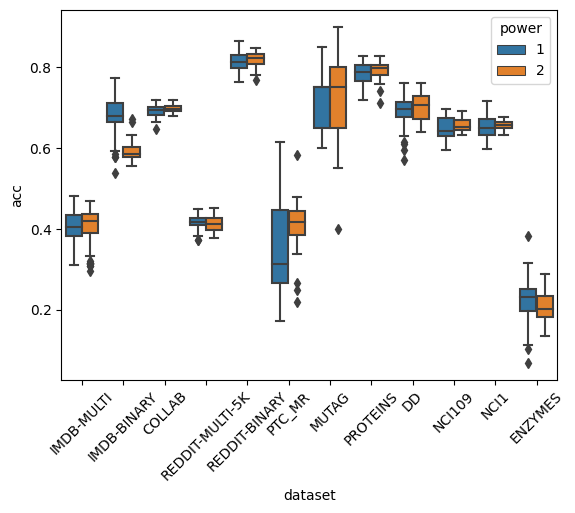

In [25]:
sns.boxplot(data=clean_df, x="dataset", y="acc", hue="power")
plt.xticks(rotation=45)

(array([0]), [Text(0, 0, 'IMDB-BINARY')])

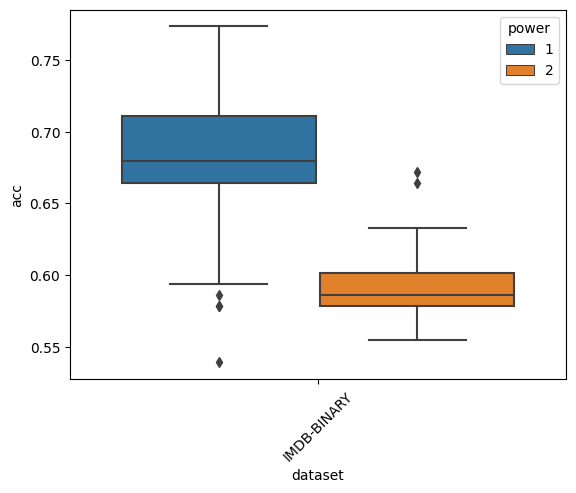

In [26]:
sns.boxplot(data=clean_df[clean_df["dataset"] == "IMDB-BINARY"], x="dataset", y="acc", hue="power")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IMDB-MULTI'),
  Text(1, 0, 'IMDB-BINARY'),
  Text(2, 0, 'COLLAB'),
  Text(3, 0, 'REDDIT-MULTI-5K'),
  Text(4, 0, 'REDDIT-BINARY'),
  Text(5, 0, 'PTC_MR'),
  Text(6, 0, 'MUTAG'),
  Text(7, 0, 'PROTEINS'),
  Text(8, 0, 'DD'),
  Text(9, 0, 'NCI109'),
  Text(10, 0, 'NCI1'),
  Text(11, 0, 'ENZYMES')])

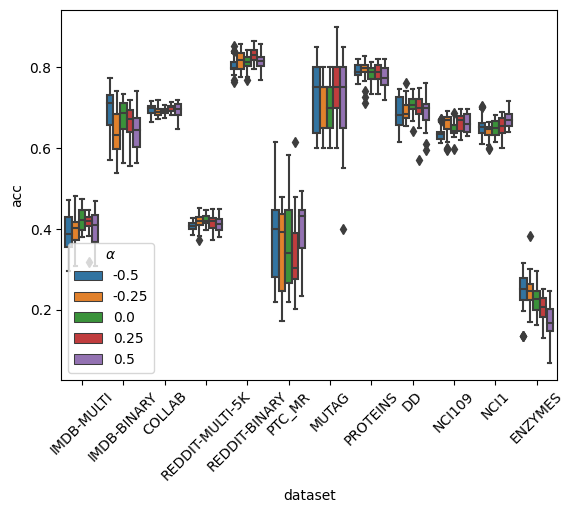

In [27]:
sns.boxplot(data=clean_df, x="dataset", y="acc", hue=r"$\alpha$")
plt.xticks(rotation=45)

<AxesSubplot:xlabel='$\\alpha$-power', ylabel='None-dataset'>

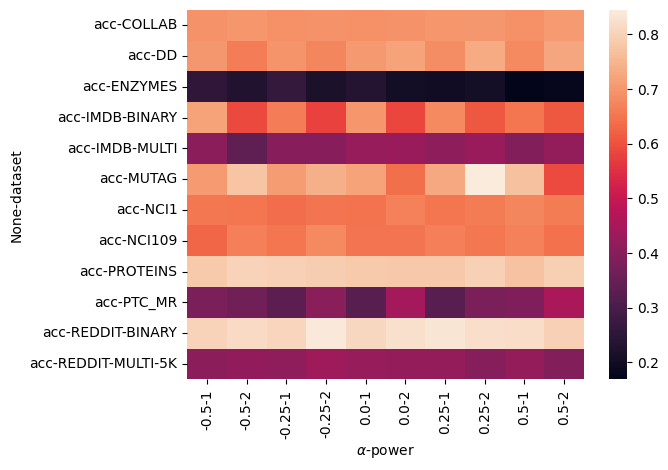

In [28]:
sns.heatmap(r2)

In [29]:
results.

SyntaxError: invalid syntax (3562696729.py, line 1)

In [ ]:
print(mean_pm_std(df, index=["datamodule/transform_args/alpha", "datamodule/transform_args/power"], columns=[ "datamodule/dataset"], value="test/acc").T.style.to_latex())

In [ ]:
df.groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]).mean()["test/acc"].reset_index().pivot(index="datamodule/dataset", columns="datamodule/transform_args/alpha")


In [ ]:
df.groupby(["datamodule/transform_args/alpha"]).mean()["test/acc"].sort_values()

In [ ]:
df.groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]).mean()["test/acc"].groupby("datamodule/dataset").idxmax().apply(lambda x: x[0]).value_counts()